In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adadelta

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip -q '/content/drive/My Drive/train_small.zip' #newdata
!unzip -q '/content/drive/My Drive/test_small.zip' #newtest
!unzip -qq '/content/drive/My Drive/final_test_small.zip' -d /content/

Mounted at /content/drive


In [3]:
num_classes = 37
input_shape = (30, 30, 1)

In [4]:
def prep(dir):
  filenames = os.listdir(dir)
  labels = np.array([int(os.path.splitext(filename)[0][:2]) for filename in filenames])
  labels = to_categorical(labels, num_classes)
  data_paths = [os.path.join(dir, filename) for filename in filenames]
  data = np.array([img_to_array(load_img(data_path, color_mode = "grayscale")) for data_path in data_paths])
  return data, labels

In [5]:
train_data, train_labels = prep('train_small')
validation_data, validation_labels = prep('test_small')
test_data , test_labels = prep('final_test_small')

In [6]:
print(f"number of training samples are {train_data.shape}")
print(f"number of validation samples are {validation_data.shape}")
print(f"number of test samples are {test_data.shape}")

number of training samples are (1850, 30, 30, 1)
number of validation samples are (37, 30, 30, 1)
number of test samples are (37, 30, 30, 1)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def aug(data, labels, factor):
    # Define the data generator for augmentation
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

    # Create a flow from the data and labels
    flow = datagen.flow(data, labels, batch_size=1)

    # Initialize arrays for augmented data and labels
    aug_data = np.zeros((data.shape[0] * factor, input_shape[0], input_shape[1], input_shape[2]), dtype='float32')
    aug_labels = np.zeros((labels.shape[0] * factor, num_classes), dtype='float32')

    # Generate augmented data
    for i in range(data.shape[0] * factor):
        batch = next(flow)  # Corrected to use `next()` function
        aug_data[i] = batch[0]  # Augmented data
        aug_labels[i] = batch[1]  # Corresponding labels

    # Rescale the augmented data to [0, 1] range if needed
    aug_data /= 255.0

    return aug_data, aug_labels

In [8]:
aug_train_data, aug_train_labels = aug(train_data, train_labels, 100)
aug_validation_data, aug_validation_labels = aug(validation_data, validation_labels, 10)
aug_test_data , aug_test_labels = aug(test_data, test_labels, 20)

In [9]:
print(f"number of augmented training samples are {aug_train_data.shape}")
print(f"number of augmented validation samples are {aug_validation_data.shape}")
print(f"number of augmented test samples are {aug_test_data.shape}")

number of augmented training samples are (185000, 30, 30, 1)
number of augmented validation samples are (370, 30, 30, 1)
number of augmented test samples are (740, 30, 30, 1)


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Check for TPU availability and set up TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print('TPU found and connected')
except:
    strategy = tf.distribute.get_strategy()  # Use default strategy (CPU/GPU)
    print('TPU not found, using default strategy')

# Compile and train the model using the strategy
with strategy.scope():
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TPU not found, using default strategy


In [11]:
# Train the model
history = model.fit(
    aug_train_data, aug_train_labels,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_data=(aug_validation_data, aug_validation_labels)
)

Epoch 1/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7733 - loss: 0.7942 - val_accuracy: 0.6946 - val_loss: 1.1558
Epoch 2/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9724 - loss: 0.0850 - val_accuracy: 0.7054 - val_loss: 1.2872
Epoch 3/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9812 - loss: 0.0560 - val_accuracy: 0.7027 - val_loss: 1.5285
Epoch 4/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9860 - loss: 0.0417 - val_accuracy: 0.7568 - val_loss: 1.0938
Epoch 5/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9885 - loss: 0.0345 - val_accuracy: 0.7378 - val_loss: 1.4379
Epoch 6/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9904 - loss: 0.0299 - val_accuracy: 0.7459 - val_loss: 1.3313
Epoch 7/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9913 - loss: 0.0259 - val_accuracy: 0.7541 - val_loss: 1.3530
Epoch 8/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9924 -

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(aug_test_data, aug_test_labels, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(aug_test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(aug_test_labels, axis=1)
# Generate a classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))

# Display a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))




24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7948 - loss: 3.6887
Test Loss: 3.630288600921631
Test Accuracy: 0.795945942401886
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.70      0.47        20
           1       0.48      1.00      0.65        20
           2       1.00      0.40      0.57        20
           3       0.15      0.20      0.17        20
           4       1.00      1.00      1.00        20
           5       1.00      0.85      0.92        20
           6       0.47      0.35      0.40        20
           7       1.00      0.60      0.75        20
           8       1.00      1.00      1.00        20
           9       0.95      1.00      0.98        20
          10       1.00      0.90      0.95        20
          11       0.91      1.00      0.95        20
          12       0.80      1.00      0.89        20
          13       0.55      0.90      0.68 

In [13]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  134924706109520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924706109712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924706110288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924706110672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924686571856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924686572432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924686572624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134924686573200: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [14]:
!zip -r model.zip saved_model/


  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 85%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 61%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


In [15]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

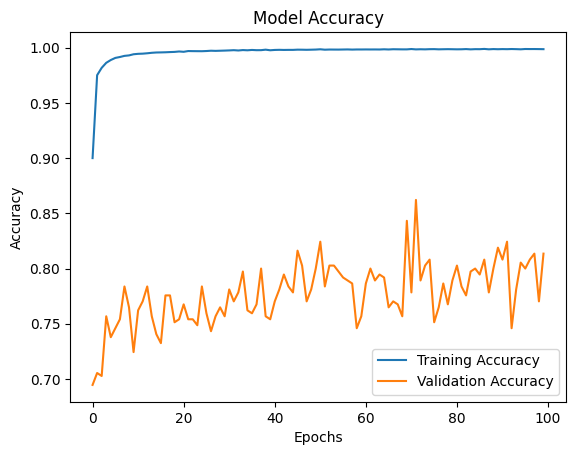

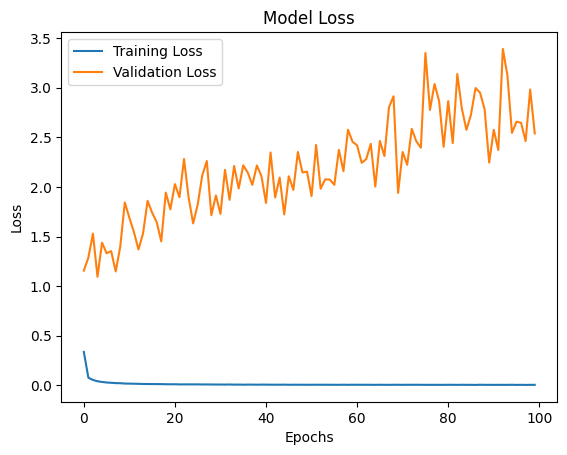

In [16]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()
